## testing what are the column header for the csv file

In [1]:
import pandas as pd
import os


In [2]:
# Replace 'your_file.csv' with the actual path to your NONAN dataset file
file_path = os.path.join("..","DATA","ma","S041_G02_D01_B01_T01.csv")
file_path


'..\\DATA\\ma\\S041_G02_D01_B01_T01.csv'

In [3]:


try:
    # Read the CSV file
    # Note: If the file has metadata in the first few rows, you might need 
    # to add the argument 'skiprows=N' (where N is the number of rows to skip).
    df = pd.read_csv(file_path)

    # Output the column names
    print(f"--- Successfully loaded {file_path} ---")
    print(f"Total Columns: {len(df.columns)}\n")
    print("Column Names:")
    for col in df.columns:
        print(f"- {col}")

except FileNotFoundError:
    print("Error: The file was not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Successfully loaded ..\DATA\ma\S041_G02_D01_B01_T01.csv ---
Total Columns: 321

Column Names:
- time
- Pelvis Accel Sensor X (mG)
- Pelvis Accel Sensor Y (mG)
- Pelvis Accel Sensor Z (mG)
- Noraxon MyoMotion-Segments-Pelvis-Acceleration-x (mG)
- Noraxon MyoMotion-Segments-Pelvis-Acceleration-y (mG)
- Noraxon MyoMotion-Segments-Pelvis-Acceleration-z (mG)
- Noraxon MyoMotion-Segments-Pelvis-Gyroscope-x (deg/s)
- Noraxon MyoMotion-Segments-Pelvis-Gyroscope-y (deg/s)
- Noraxon MyoMotion-Segments-Pelvis-Gyroscope-z (deg/s)
- Pelvis course (deg)
- Pelvis pitch (deg)
- Pelvis roll (deg)
- Pelvic Tilt LT (deg)
- Pelvic Obliquity LT (deg)
- Pelvic Rotation LT (deg)
- Pelvic Obliquity RT (deg)
- Pelvic Rotation RT (deg)
- Lower spine Accel Sensor X (mG)
- Lower spine Accel Sensor Y (mG)
- Lower spine Accel Sensor Z (mG)
- Noraxon MyoMotion-Segments-Lower spine-Acceleration-x (mG)
- Noraxon MyoMotion-Segments-Lower spine-Acceleration-y (mG)
- Noraxon MyoMotion-Segments-Lower spine-Acceleratio

In [ ]:
pd.DataFrame(df.columns).to_csv("column header.csv")

In [ ]:
df.head(10)

In [ ]:
cl=df.columns.to_list()

In [ ]:
temp=cl.copy()

In [ ]:
for c,_ in enumerate(temp):
    temp[c]=_.split(" ")

In [ ]:
for _ in zip(temp,cl):
    print(_)

In [ ]:
_=pd.read_csv("column header.csv")

In [10]:
cl=df.columns.to_list()[1:]

In [14]:
len(cl)

320

In [ ]:
cl= _['0'].astype(str).tolist()

In [15]:
with open("column.txt", "w") as f:
    f.write("\n".join(cl))


In [ ]:
def chunk_list(lst, chunk_size=17):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [ ]:
segments = chunk_list(cl, 17)

In [ ]:
dict={}
for c,_ in enumerate(segments):
    dict[c]=_

In [ ]:
pprint.pprint(dict)

In [ ]:
body_parts = [
    "Pelvis", "Thorax", "Trunk", "Foot", 
    "Shank", "Thigh", "Arm", "Forearm", 
    "Hand", "Head", "Lumbar", "Cervical"
]
measurement_types = [
    "Accel", "Gyro", "Orientation", 
    "Angle", "Position", "Velocity"
]

In [ ]:
from collections import defaultdict

def group_by_keywords(strings, keywords):
    groups = defaultdict(list)
    groups["Uncategorized"] = []

    for s in strings:
        found = False
        for k in keywords:
            if k.lower() in s.lower():
                groups[k].append(s)
                found = True
                break
        if not found:
            groups["Uncategorized"].append(s)

    return groups


In [ ]:
group_A = group_by_keywords(cl, body_parts)
group_A

In [ ]:
group_B = group_by_keywords(cl, measurement_types)
group_B

# extracted feature tests and validate before using

In [10]:
file="S001_G01_D01_B01_T01-target_features.csv"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Load data
df = pd.read_csv(file)

## code for clipping - symmetry L/R - Frequency Analysis - Static Noise" Check 

### text

This result is actually **good news**, even if it seems ambiguous.

**Interpretation:**

  * Standard Gravity is **\~1000 mG** ($1G$).
  * Your result is **354.60 mG**.
  * **Conclusion:** Since $354 \ll 1000$, the massive constant gravity vector is **NOT present** in your data. If gravity were still there, your mean magnitude would be at least 1000.
  * **What is the 354 mG?** This likely represents the **average "energy" of the walking motion** itself (Linear Acceleration) plus some sensor bias. Since you calculated the mean over the whole file (walking), getting a non-zero value is expected—walking generates force\!

#### **Action Plan: Yes, Filter It.**

Even though gravity is mostly gone, you should still apply the **High-Pass Filter (0.5 Hz)**.

  * **Why?** Neural networks expect data centered exactly at **0**. If your mean is 354, your data is "biased" or shifted. The High-Pass filter will remove this offset and center your data, ensuring the model learns the *shape* of the movement, not the constant offset.

-----

#### **Validation & Analysis for Your 6-Axis Data**

Before training, you should run these 4 specific checks to ensure your "Option B" data is healthy.

##### **1. The "Clipping" Check (Saturation)**

Sensors have limits (e.g., $\pm 16G$). If the user stomps hard, the sensor might "max out," cutting off the peak of the data. This destroys the heel-strike fingerprint.

  * **Check:** Look for values hitting exactly $\pm 16000$, $\pm 8000$, or $\pm 2000$ (depending on range settings).
  * **Visual:** Plot the `Foot_LT` Acceleration. If the peaks look "flat" (like a table) instead of sharp, that trial is corrupted.

##### **2. The Symmetry Check (Left vs. Right)**

You are using both Left and Right leg sensors. They must be synchronized but **out of phase** (when Left moves, Right is planted).

  * **Check:** Plot `Shank_LT_Accel_X` and `Shank_RT_Accel_X` on the same graph.
  * **Pass:** They should look like sine waves shifted by 180 degrees (opposite peaks).
  * **Fail:** If they peak at the same time, the sensors might be swapped or labeled wrong.

##### **3. The "Static Noise" Check**

Since you have "Option B" data which claims to be filtered, verify the noise levels.

  * **Check:** Find a region where the user is standing still (usually the first 2-3 seconds).
  * **Pass:** Gyroscope values should be near **0 deg/s** (e.g., \< 5 deg/s).
  * **Fail:** If the Gyro reads constant 20-30 deg/s while standing, you have **Gyro Drift**. You must subtract this mean value from the whole signal.

##### **4. Frequency Analysis (FFT)**

Walking happens at specific frequencies (1 Hz - 3 Hz).

  * **Check:** Run a Fast Fourier Transform (FFT) on the `Upper_Spine` acceleration.
  * **Pass:** You should see a clear, dominant spike around **1.5 Hz - 2.0 Hz** (Step frequency).
  * **Fail:** If the spectrum is flat or noisy with no peaks, the data might be over-filtered or corrupted.


### Code


In [2]:


# Select a sensor that is relatively stable (e.g., Pelvis or Spine)
sensor_prefix = "Noraxon MyoMotion-Segments-Pelvis-Acceleration"

# Extract X, Y, Z (Assuming mG units as per your CSV)
acc_x = df[f"{sensor_prefix}-x (mG)"].values
acc_y = df[f"{sensor_prefix}-y (mG)"].values
acc_z = df[f"{sensor_prefix}-z (mG)"].values

In [3]:

# Calculate Magnitude
magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

# RESULTS
mean_val = np.mean(magnitude)
print(f"Mean Acceleration Magnitude: {mean_val:.2f} mG")

if mean_val > 800:
    print("CONCLUSION: Gravity is PRESENT (~1000 mG). You MUST apply High-Pass Filter.")
elif mean_val < 200:
    print("CONCLUSION: Gravity is REMOVED. Do NOT filter.")
else:
    print("CONCLUSION: Ambiguous. Check units or calibration.")

Mean Acceleration Magnitude: 354.60 mG
CONCLUSION: Ambiguous. Check units or calibration.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Load your data
file_path = "your_data.csv"  # Replace with actual file
df = pd.read_csv(file)

In [6]:

# --- 1. CLIPPING CHECK ---
foot_acc = df['Noraxon MyoMotion-Segments-Foot LT-Acceleration-z (mG)'].values
max_val = np.max(np.abs(foot_acc))
print(f"Max Foot Acceleration: {max_val} mG")
if max_val >= 16000:  # Adjust based on likely sensor range (16G)
    print("WARNING: Possible Clipping Detected (Peaks flattened).")


Max Foot Acceleration: 6784.375596 mG


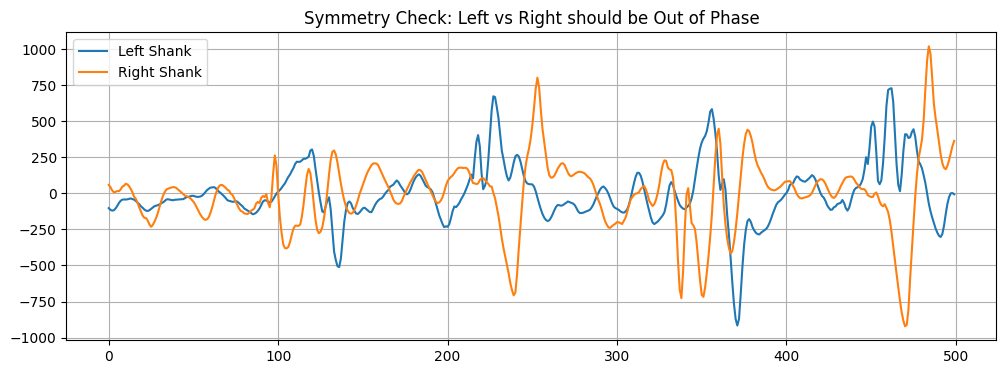

In [7]:

# --- 2. SYMMETRY CHECK (Visual) ---
plt.figure(figsize=(12, 4))
plt.plot(df['Noraxon MyoMotion-Segments-Shank LT-Acceleration-x (mG)'].values[:500], label='Left Shank')
plt.plot(df['Noraxon MyoMotion-Segments-Shank RT-Acceleration-x (mG)'].values[:500], label='Right Shank')
plt.title("Symmetry Check: Left vs Right should be Out of Phase")
plt.legend()
plt.grid()
plt.savefig("symmetry_check.png")
# User: Look at 'symmetry_check.png'. Peaks should alternate.


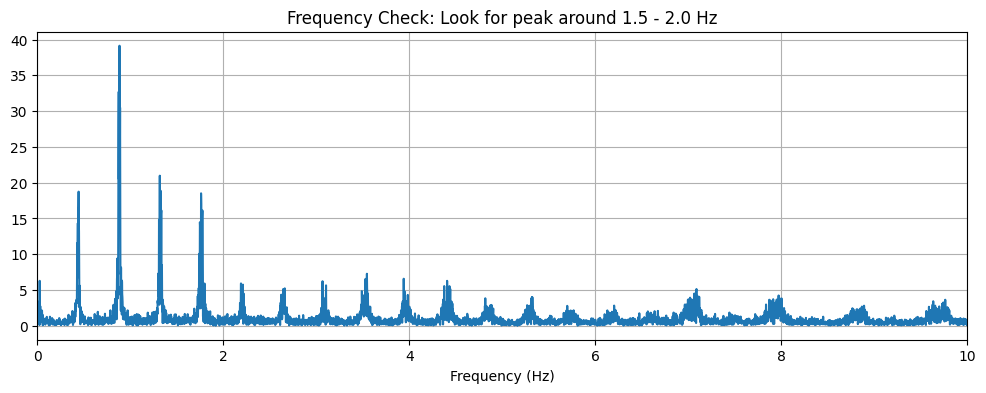

In [8]:

# --- 3. FREQUENCY CHECK (FFT) ---
spine_acc = df['Noraxon MyoMotion-Segments-Upper spine-Acceleration-x (mG)'].values
N = len(spine_acc)
T = 1.0 / 100.0  # Sampling rate 100Hz
yf = fft(spine_acc)
xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(12, 4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 10) # Focus on 0-10 Hz
plt.title("Frequency Check: Look for peak around 1.5 - 2.0 Hz")
plt.xlabel("Frequency (Hz)")
plt.grid()
plt.savefig("frequency_check.png")

## gyro drfit or not check

### Code

In [ ]:

# --- CONFIGURATION ---
SAMPLING_RATE = 200  # Updated to 200 Hz
STATIC_DURATION = 2 # We want to check the first 2 seconds
THRESHOLD_FAIL = 5.0 # deg/s tolerance

# Calculate samples based on new rate (2.0s * 200Hz = 400 samples)
num_samples = int(SAMPLING_RATE * STATIC_DURATION)


In [12]:

# List of sensors to check
sensors = [
    "Pelvis", 
    "Upper spine", 
    "Shank LT", "Shank RT", 
    "Foot LT", "Foot RT"
]

print(f"Checking First {num_samples} Samples ({STATIC_DURATION}s @ {SAMPLING_RATE}Hz)...")
print(f"{'SENSOR':<15} | {'AXIS':<5} | {'MEAN (deg/s)':<12} | {'STATUS'}")
print("-" * 50)



Checking First 400 Samples (2.0s @ 200Hz)...
SENSOR          | AXIS  | MEAN (deg/s) | STATUS
--------------------------------------------------


In [18]:
drift_detected = False

for sensor in sensors:
    for axis in ['x', 'y', 'z']:
        col_name = f"Noraxon MyoMotion-Segments-{sensor}-Gyroscope-{axis} (deg/s)"
        
        if col_name in df.columns:
            # 1. Isolate the static window
            static_data = df[col_name].values[:num_samples]
            
            # 2. Calculate Drift (Mean offset)
            bias = np.mean(static_data)
            
            # 3. Check Threshold
            status = "PASS"
            if abs(bias) > THRESHOLD_FAIL:
                status = "**FAIL**"
                drift_detected = True
            
            print(f"{sensor:<15} | {axis:<5} | {bias:10.4f}   | {status}")

if drift_detected:
    print("\n[!] DRIFT DETECTED: Apply Bias Subtraction (Mean Removal).")
    print(f"\n SAMPLING_RATE={SAMPLING_RATE} | STATIC_DURATION:{STATIC_DURATION} | num_samples {num_samples}")
else:
    print("\n[OK] Sensors are stable. No extra filtering needed.")
    print(f"\n SAMPLING_RATE={SAMPLING_RATE} | STATIC_DURATION:{STATIC_DURATION} | num_samples {num_samples}")

Pelvis          | x     |    -0.7196   | PASS
Pelvis          | y     |    -2.0184   | PASS
Pelvis          | z     |     1.3852   | PASS
Upper spine     | x     |    -0.6021   | PASS
Upper spine     | y     |     0.3513   | PASS
Upper spine     | z     |    -0.6744   | PASS
Shank LT        | x     |     5.6122   | **FAIL**
Shank LT        | y     |   -11.1837   | **FAIL**
Shank LT        | z     |   -13.7596   | **FAIL**
Shank RT        | x     |    -1.1121   | PASS
Shank RT        | y     |    12.2338   | **FAIL**
Shank RT        | z     |    13.1136   | **FAIL**
Foot LT         | x     |   -20.0345   | **FAIL**
Foot LT         | y     |    23.7565   | **FAIL**
Foot LT         | z     |    -3.3214   | PASS
Foot RT         | x     |    11.4087   | **FAIL**
Foot RT         | y     |     0.6924   | PASS
Foot RT         | z     |    14.1759   | **FAIL**

[!] DRIFT DETECTED: Apply Bias Subtraction (Mean Removal).

 SAMPLING_RATE=200 | STATIC_DURATION:2 | num_samples 400


In [19]:

print(f"{'SENSOR':<15} | {'METRIC':<15} | {'VALUE':<10} | {'STATUS'}")
print("-" * 60)

# --- 1. FOOT VALIDATION (Find Stance Phase) ---
for foot in ["Foot LT", "Foot RT"]:
    # Construct Gyro Magnitude
    gx = df[f"Noraxon MyoMotion-Segments-{foot}-Gyroscope-x (deg/s)"].values
    gy = df[f"Noraxon MyoMotion-Segments-{foot}-Gyroscope-y (deg/s)"].values
    gz = df[f"Noraxon MyoMotion-Segments-{foot}-Gyroscope-z (deg/s)"].values
    gyro_mag = np.sqrt(gx**2 + gy**2 + gz**2)
    
    # Find the "Quietest" 100ms window (20 samples)
    # We slide a window and find the minimum average movement
    window_size = int(0.1 * SAMPLING_RATE)
    # Fast way to find min rolling average
    series = pd.Series(gyro_mag)
    min_motion = series.rolling(window_size).mean().min()
    
    # Threshold: Stance phase should be very quiet (< 30 deg/s is decent for walking)
    status = "PASS" if min_motion < 30.0 else "FAIL (Drift?)"
    
    print(f"{foot:<15} | Min Motion (0.1s) | {min_motion:.2f} deg/s | {status}")


SENSOR          | METRIC          | VALUE      | STATUS
------------------------------------------------------------
Foot LT         | Min Motion (0.1s) | 4.53 deg/s | PASS
Foot RT         | Min Motion (0.1s) | 5.98 deg/s | PASS


In [20]:

# --- 2. SPINE/PELVIS VALIDATION (Long-term Mean) ---
# We assume the user didn't spin in circles for 4 minutes.
for sensor in ["Pelvis", "Upper spine"]:
    # Check Z-axis (Yaw/Turning)
    col_z = f"Noraxon MyoMotion-Segments-{sensor}-Gyroscope-z (deg/s)"
    
    if col_z in df.columns:
        mean_val = df[col_z].mean()
        
        # Threshold: Over 4 mins, mean should be close to 0
        # If > 5 deg/s, it implies constant rotation (Drift)
        status = "PASS" if abs(mean_val) < 5.0 else "WARNING (Bias?)"
        
        print(f"{sensor:<15} | Mean Z-Axis     | {mean_val:.2f} deg/s  | {status}")

Pelvis          | Mean Z-Axis     | -0.56 deg/s  | PASS
Upper spine     | Mean Z-Axis     | -1.11 deg/s  | PASS


In [21]:

print(f"{'SENSOR':<15} | {'METRIC':<15} | {'VALUE':<10} | {'STATUS'}")
print("-" * 60)

# --- 1. FOOT VALIDATION (Find Stance Phase) ---
for foot in ["Foot LT", "Foot RT"]:
    # Construct Gyro Magnitude
    gx = df[f"Noraxon MyoMotion-Segments-{foot}-Gyroscope-x (deg/s)"].values
    gy = df[f"Noraxon MyoMotion-Segments-{foot}-Gyroscope-y (deg/s)"].values
    gz = df[f"Noraxon MyoMotion-Segments-{foot}-Gyroscope-z (deg/s)"].values
    gyro_mag = np.sqrt(gx**2 + gy**2 + gz**2)
    
    # Find the "Quietest" 100ms window (20 samples)
    # We slide a window and find the minimum average movement
    window_size = int(0.1 * SAMPLING_RATE)
    # Fast way to find min rolling average
    series = pd.Series(gyro_mag)
    min_motion = series.rolling(window_size).mean().min()
    
    # Threshold: Stance phase should be very quiet (< 30 deg/s is decent for walking)
    status = "PASS" if min_motion < 30.0 else "FAIL (Drift?)"
    
    print(f"{foot:<15} | Min Motion (0.1s) | {min_motion:.2f} deg/s | {status}")


SENSOR          | METRIC          | VALUE      | STATUS
------------------------------------------------------------
Foot LT         | Min Motion (0.1s) | 4.53 deg/s | PASS
Foot RT         | Min Motion (0.1s) | 5.98 deg/s | PASS


In [22]:

# --- 2. SPINE/PELVIS VALIDATION (Long-term Mean) ---
# We assume the user didn't spin in circles for 4 minutes.
for sensor in ["Pelvis", "Upper spine"]:
    # Check Z-axis (Yaw/Turning)
    col_z = f"Noraxon MyoMotion-Segments-{sensor}-Gyroscope-z (deg/s)"
    
    if col_z in df.columns:
        mean_val = df[col_z].mean()
        
        # Threshold: Over 4 mins, mean should be close to 0
        # If > 5 deg/s, it implies constant rotation (Drift)
        status = "PASS" if abs(mean_val) < 5.0 else "WARNING (Bias?)"
        
        print(f"{sensor:<15} | Mean Z-Axis     | {mean_val:.2f} deg/s  | {status}")

Pelvis          | Mean Z-Axis     | -0.56 deg/s  | PASS
Upper spine     | Mean Z-Axis     | -1.11 deg/s  | PASS


## Symetry && step validation

### Code:

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


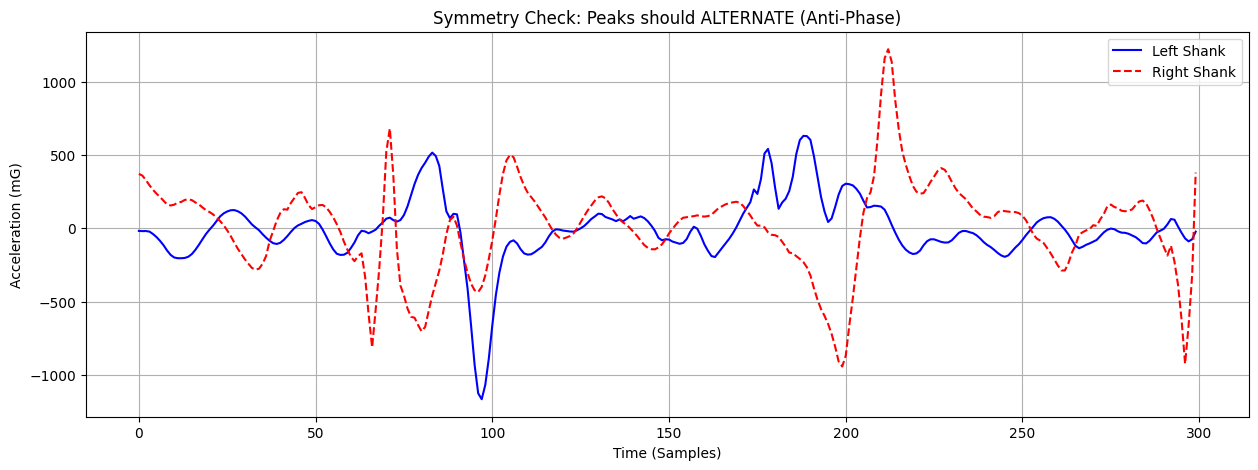

In [27]:
df = pd.read_csv(file)

# --- 1. SYMMETRY VISUALIZATION ---
# Using Shank Acceleration X (Vertical axis usually has strongest swing signal)
# Check your specific CSV to confirm if X or Z is vertical.
left_shank = df['Noraxon MyoMotion-Segments-Shank LT-Acceleration-x (mG)'].values
right_shank = df['Noraxon MyoMotion-Segments-Shank RT-Acceleration-x (mG)'].values

plt.figure(figsize=(15, 5))
plt.plot(left_shank[500:800], label='Left Shank', color='blue')
plt.plot(right_shank[500:800], label='Right Shank', color='red', linestyle='--')
plt.title("Symmetry Check: Peaks should ALTERNATE (Anti-Phase)")
plt.xlabel("Time (Samples)")
plt.ylabel("Acceleration (mG)")
plt.legend()
plt.grid(True)
plt.show()


In [28]:

# --- 2. STEP COUNT CONSISTENCY ---
# Using Foot Acceleration Magnitude to detect steps (Impacts)
# Note: Since you dropped Gyro, we use Accel Peaks for this check.
left_foot_mag = np.linalg.norm(df[['Noraxon MyoMotion-Segments-Foot LT-Acceleration-x (mG)', 
                                    'Noraxon MyoMotion-Segments-Foot LT-Acceleration-y (mG)', 
                                    'Noraxon MyoMotion-Segments-Foot LT-Acceleration-z (mG)']].values, axis=1)

right_foot_mag = np.linalg.norm(df[['Noraxon MyoMotion-Segments-Foot RT-Acceleration-x (mG)', 
                                    'Noraxon MyoMotion-Segments-Foot RT-Acceleration-y (mG)', 
                                    'Noraxon MyoMotion-Segments-Foot RT-Acceleration-z (mG)']].values, axis=1)

# Detect peaks (Heel Strikes)
# height=2000 mG is a rough threshold for a heel strike impact
peaks_L, _ = find_peaks(left_foot_mag, height=2000, distance=50)
peaks_R, _ = find_peaks(right_foot_mag, height=2000, distance=50)

print(f"Left Steps Detected: {len(peaks_L)}")
print(f"Right Steps Detected: {len(peaks_R)}")

if abs(len(peaks_L) - len(peaks_R)) > 2:
    print("WARNING: Step count mismatch! Check sensor attachment or thresholds.")
else:
    print("SUCCESS: Step counts are consistent.")

Left Steps Detected: 422
Right Steps Detected: 423
SUCCESS: Step counts are consistent.
